Example of inversion problem
===============================

This notebook provides an example on how to use a simple model (junsteak) in an inversion problem

Made during the JAXathon 2025 at Insitut des Geosciences et de l'Environnement (IGE)
The event has been organized by Julien LeSommer

Notebook by the group of the project 'simple_ocean_models'.  
By: Marta Mrozowska, Valentin Bellemin-Laponaz, Florian Le Guillou, Sammy Metref, Hugo Jacquet  
Date: 13th of March 2025


Create an environment with the needed packages from ENV_for_junsteak.txt  

In [1]:
# basic imports
import matplotlib.pyplot as plt
import xarray as xr
# Jax related
import jax
import jax.tree_util as jtu
import optax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from diffrax import Euler
import equinox as eqx
# my imports
from junsteak import UNSTKmodel

Model setup
-----------

Here we define the parameters of the model. The word 'parameters' is very general, what is fixed, what is forcing and what is a control parameter will be defined during the minimization process using Equinox filters.

In [2]:
# model setup
Nl=1            # number of layers
# initial conditions
U0 = 0.0        # (m/s), zonal velocity
V0 = 0.0        # (m/s), meridional velocity
# forcing
TAx = 0.0 # not used, idealized forcing in the model class (to be made cleaner)
TAy = 0.02
fc = 1e-4

Ktarget     = jnp.asarray([-10.,-9.])
Kinitial    = jnp.asarray([-9.,-8.5]) # [-9.,-8.5]

# Time integration
solver=Euler()  # solver to use
dt=60           # time step
t0=0            # initial time
t1=84600        # final time

# optimizer things
AD_mode = 'F' # 'forward' 'backward
itmax = 100
lr = 1e-1
opt = optax.adam(lr)
#opt = optax.lbfgs() # not working just like this, need more investigation ...

Starting point for a realistic forcing

In [3]:
# adding a realistic forcing
# file_forcing = '/home/jacqhugo/Datlas_2025/Reconstruct_inertial_current/JAXathon/croco_1h_inst_surf_2006-02-01-2006-02-28_cons_-50.0_-35.0.nc'
# ds_f = xr.open_dataset(file_forcing)
# dt_forcing= 3600 # s
# time_forcing = jnp.arange(0,len(ds_f.time)*dt_forcing,dt_forcing, dtype=float)
# ds_f['time'] = time_forcing
# TAx = ds_f.oceTAUX.sel(time=slice(t0,t1))
# TAy = ds_f.oceTAUY.sel(time=slice(t0,t1))
# time_forcing = jnp.arange(t0,t1,dt_forcing)
# TAx_t = diffrax.LinearInterpolation(time_forcing, TAx)
# TAy_t = diffrax.LinearInterpolation(time_forcing, TAy)

Experiment setup
--------------------

Making a target trajectory from 1 run of the model, using control parameters `Ktarget`

In [4]:
# Initialise model = class instanciation and initial state and forcing
true_model = UNSTKmodel(U0=U0, V0=V0, Nl=1, TAx=TAx, TAy=TAy, K=Ktarget, fc=fc, solver=solver, AD_mode=AD_mode)  
# truth
ltime = jnp.arange(0,84600,60)
sol = true_model(t0=t0,t1=t1,dt=dt,save_traj=ltime)
truth = sol.ys

ForwardMode()


Making Observations extracted from the true trajectory

In [5]:
# Making observations from truth
time_obs = jnp.arange(t0,t1,60*20+600)
sol = true_model(t0=t0,t1=t1,dt=dt,save_traj=time_obs)
obs = sol.ys

ForwardMode()


Computing a first guess with `Kinitial`, after having setup a new model.  
This new model will be the one that we will work on in the following.  
This new model has the same forcing as the target model

In [6]:
# New model to use in minimisation
#K=jnp.asarray([-9.,-8.5]) # [-10,-9] # here we need 1) a jax array 2) that consist of floats
mymodel = UNSTKmodel(U0=U0, V0=V0, Nl=1, TAx=TAx, TAy=TAy, K=Kinitial, fc=fc, solver=solver, AD_mode=AD_mode)  
first_guess = mymodel(t0=t0,t1=t1,dt=dt,save_traj=ltime).ys

ForwardMode()


Minimisation process
--------------------

Filtering to define what is static and what is dynamic

In [7]:
# filter model attribute
# this is where the magic happens:
#   we filter the class attributes that we dont want to be differentiated
#   (by default all non array/float are filtered out)
filter_spec = jtu.tree_map(lambda arr: False, mymodel) # keep nothing
filter_spec = eqx.tree_at( lambda tree: tree.K, filter_spec, replace=True) # keep only K

Defining the loss function, this is model specific

Note: the call of the function should be the same for any physical model

In [8]:
def loss_fn(sol,obs): # <- this is problem specific, but also model specific
    return jnp.mean( (sol[0]-obs[0])**2 + (sol[1]-obs[1])**2 )

Minimizer build parts

Note: This could be wrapped into a myminimizer function ...

In [9]:
# this should be general enough to not need any modification in another model
def loss_grad( dynamic_model, static_model, tobs, t0, t1, dt, obs):
    mymodel = eqx.combine(dynamic_model, static_model)
    sol = mymodel(t0, t1, dt, save_traj=tobs).ys
    return loss_fn(sol,obs)

def loss_for_jacfwd(sol,obs):
    y = loss_fn(sol,obs)
    return y, y # <- trick to have a similar behavior than value_and_grad (but here returns grad, value)

def loss_jacfwd( dynamic_model, static_model, tobs, t0, t1, dt, obs):
    mymodel = eqx.combine(dynamic_model, static_model)
    sol = mymodel(t0, t1, dt, save_traj=tobs).ys
    return loss_for_jacfwd(sol,obs)


if AD_mode=='F':
    dloss_fn = eqx.filter_jacfwd(loss_jacfwd, has_aux=True)
elif AD_mode=='B':
    dloss_fn = eqx.filter_value_and_grad(loss_grad)

# this function is common to all model, nothing is specific to the model    
# |
# v
# one step of the minimizer
@eqx.filter_jit
def step_minimize( model, opt_state, filter_spec, t0, t1, dt, tobs, obs):
    dynamic_model, static_model = eqx.partition(model, filter_spec)
    #value, grad = loss_grad(dynamic_model, static_model, tobs, t0, t1, dt, obs)
    grad, value  = dloss_fn(dynamic_model, static_model, tobs, t0, t1, dt, obs)
    updates, opt_state = opt.update(grad, opt_state)
    model = eqx.apply_updates(model, updates)
    return value, model, opt_state

Minimization process, starting from `Kinitial`

In [10]:
# initialise optimizer
opt_state = opt.init(mymodel)
# optimize loop
for it in range(itmax):
    value, mymodel, opt_state = step_minimize(mymodel, opt_state, filter_spec, t0, t1, dt, time_obs, obs)
    print("it, J, K :",it, value, mymodel.K) # value, mymodel
print('Final K is:',mymodel.K)
newsolution = mymodel(t0, t1, dt, save_traj=ltime).ys

ForwardMode()
it, J, K : 0 0.008494855015484618 [-9.09999996 -8.4000003 ]
ForwardMode()
it, J, K : 1 0.005846709252166879 [-9.19804548 -8.30192639]
it, J, K : 2 0.00395917931154199 [-9.29285336 -8.20767333]
it, J, K : 3 0.0026628719924078 [-9.3833209 -8.1196266]
it, J, K : 4 0.0018096952601524474 [-9.46861556 -8.04049073]
it, J, K : 5 0.0012750777938606071 [-9.54820605 -7.97288902]
it, J, K : 6 0.00095841271069781 [-9.62184058 -7.91884558]
it, J, K : 7 0.0007822891024230817 [-9.68949228 -7.87940557]
it, J, K : 8 0.0006905878293215271 [-9.75129428 -7.85458106]
it, J, K : 9 0.0006452909588300193 [-9.80748062 -7.84357923]
it, J, K : 10 0.0006223865673759571 [-9.8583404  -7.84512979]
it, J, K : 11 0.0006077467638814281 [-9.90418603 -7.85776441]
it, J, K : 12 0.0005937071274001053 [-9.94533318 -7.87999794]
it, J, K : 13 0.0005765935550988788 [-9.98208901 -7.9104233 ]
it, J, K : 14 0.0005550871935846521 [-10.01474615  -7.9477498 ]
it, J, K : 15 0.0005291973633829201 [-10.04358009  -7.9908104

Plotting
---------

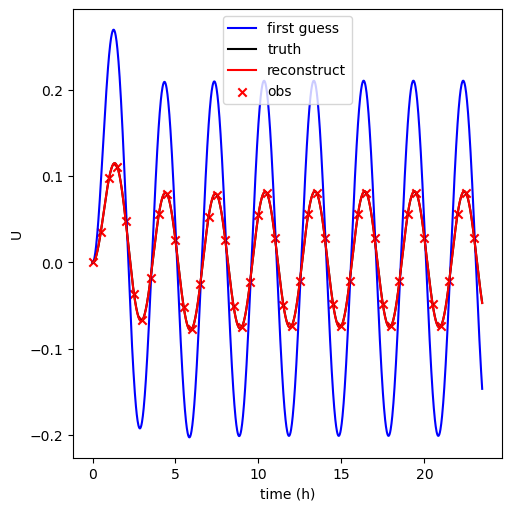

In [11]:
fig, ax = plt.subplots(1,1,figsize = (5,5),constrained_layout=True,dpi=100)
ax.plot(ltime/3600, first_guess[0], c='b',label='first guess')
ax.plot(ltime/3600,truth[0],c='k',label='truth')
ax.plot(ltime/3600,newsolution[0],c='r',label='reconstruct')
ax.scatter(time_obs/3600,obs[0],marker='x',c='r',label='obs')
ax.set_ylabel('U')
ax.set_xlabel('time (h)')
fig.savefig('minimisation_example.png')
plt.legend()
plt.show()